In [1]:
#### ALL NOTEBOOK SHOULD HAVE SOME VERSION OF THIS #####################################
########################################################################################
%load_ext autoreload
%autoreload 2
import os
import sys

currentdir = os.getcwd()
# go to root directory. change the # of os.path.dirnames based on where currentdir is
parentdir = os.path.dirname(os.path.dirname(currentdir)) 
# chek where I'm at. if I go too far up the tree, go back
if 'Protein-Purification-Model-Public' not in parentdir: parentdir = currentdir
if parentdir not in sys.path: sys.path.insert(0,parentdir)
########################################################################################

In [3]:
import utils
import visualization.simple_data_vis as vis
import surrogate_models.dab_nn_defs as engine
import kerastuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
# load data from just-private/data
filename = 'mol_res_scan_results_7.csv'
data = utils.load_data(parentdir, filename)

# since currently data is just one big dataframe, select model inputs as X and purity, yield as Y
x = [*data.columns[:2],*data.columns[4:]]
y = data.columns[2:4]

In [5]:
# remove impossible data?
data = utils.preprocessing([data,], bounds = {'yield':[0,1],'purity':[0,1]})[0]

In [6]:
# _,_ = histograms(data,x,y)

In [7]:
# split data into train and test
train_x, test_x, train_y, test_y = utils.chroma_train_test_split(data, x, y)

In [8]:
# standarize inputs
train_x, test_x, scaler_x = utils.preprocessing(
    [train_x, test_x], 
    standarize = True, 
    skip = ['cut 1','cut 2']
    )

train = [train_x, train_y]
test = [test_x, test_y]

In [9]:
# define models to test out
dlr = engine.create_deterministic_linear_regressor(
    FEATURE_NAMES = x,
    TARGET_NAMES = y,
    name = 'DLR_'+filename[:-4]
)

plr = engine.create_probabilistic_linear_regressor(
    FEATURE_NAMES = x,
    TARGET_NAMES = y,
    name = 'PLR_'+filename[:-4],
)

dnn = engine.create_deterministic_nn(
    FEATURE_NAMES = x,
    TARGET_NAMES = y,
    hidden_units = [16,8,4],
    name = 'DNN_'+filename[:-4]
)

pnn = engine.create_probabilistic_nn(
    FEATURE_NAMES = x,
    TARGET_NAMES = y,
    hidden_units = [16,8,4,],
    name = 'PNN_'+filename[:-4],
)

models = [dlr,plr,dnn,pnn]

In [10]:
dlr.summary()

Model: "DLR_mol_res_scan_results_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 18)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1)            19          input[0][0]                      
__________________________________________________________________________________________________
yield (Dense)                   (None, 1)            2           dense[0][0]                      
__________________________________________________________________________________________________
purity (Dense)                  (None, 1)            2           dense[0][0]                      
Total params: 23
Trainable params: 23
Non-trainable params: 0
___________

In [11]:
# train all the models under the same conditions
learning_rate = 0.01
epochs = 100
optimizer = 'Adam' # change manually or come up with dictionary?
losses = ['mean_squared_error', engine.negative_loglikelihood]*2
loss_weights = (1/train_y.mean().div(train_y.mean().max())).round(2).to_dict() # pretty much correcting for mean
histories = {}

for m,l in zip(models,losses):
    histories[utils.get_model_name(m,filename)] = engine.run_experiment(
        model = m, 
        loss = {y[0]:l,y[1]:l},
        loss_weights = loss_weights,
        optimizer = tf.keras.optimizers.Adam,
        learning_rate = learning_rate,
        num_epochs = epochs,
        train_dataset = train, 
        test_dataset = test,
        verbose = 0,
        log = 0
        )

settings = {'learning_rate' : learning_rate,
            'epochs' : epochs,
            'optimizer': optimizer,
            'loss_weights': loss_weights,
            'dataset' : filename}

Start training the model DLR_mol_res_scan_results_7 ...
Evaluating model performance...
Train MSE: 0.733
Test MSE: 0.681
Start training the model PLR_mol_res_scan_results_7 ...
Evaluating model performance...
Train MSE: 0.873
Test MSE: 0.796
Start training the model DNN_mol_res_scan_results_7 ...
Evaluating model performance...
Train MSE: 0.025
Test MSE: 0.029
Start training the model PNN_mol_res_scan_results_7 ...
Evaluating model performance...
Train MSE: 0.018
Test MSE: 0.018


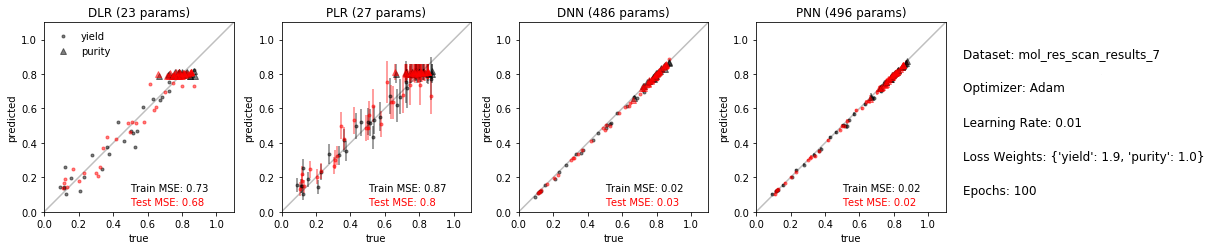

In [12]:
# check model predictions
vis.scatter_hats(models, train, test, settings, N = 25)

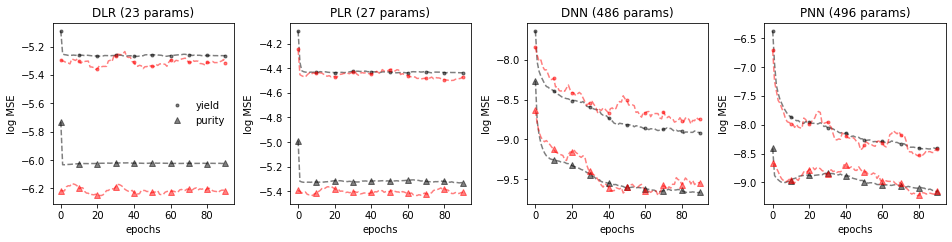

In [13]:
# check training process (note: these are metrics not losses)
vis.training_curves(models, y, settings, histories, smoothing = int(settings['epochs']*0.1))

SCRATCH

In [ ]:
a = test[0].sample(50)
lol = plr(a.to_numpy())

b=test[1].loc[a.index]

In [ ]:
scaler_y.inverse_transform(np.array([lol[0].numpy(),lol[1].numpy()]).squeeze().T)

In [ ]:
import numpy as np
means = scaler_y.inverse_transform(np.array([lol[0].mean().numpy(),lol[1].mean().numpy()]).squeeze().T)
stddevs = scaler_y.inverse_transform(np.array([lol[0].stddev().numpy(),lol[1].stddev().numpy()]).squeeze().T)
plt.errorbar(scaler_y.inverse_transform(b)[:,0],means[:,0],stddevs[:,0],fmt='o')
plt.errorbar(scaler_y.inverse_transform(b)[:,1],means[:,1],stddevs[:,1],fmt='o')
plt.plot([0,1],[0,1],'--')

In [ ]:
def model_builder(hp):
    hp_layers = hp.Int('layers', min_value=2, max_value=10)
    hp_units = hp.Int('units', min_value=4, max_value = 32, step=2)
    for L in range(hp_layers):
        hidden_units = [np.ceil(hp_units**(l/L)) for l in range(L)]

    # define Probabilistic Bayesian Neural Network 
    model = engine.create_probablistic_bnn_model(
        FEATURE_NAMES = data.columns[4:],
        TARGET_NAMES = data.columns[2:4], 
        train_size = train_size, 
        n_outputs = y.shape[1],
        hidden_units = hidden_units,
        name = 'PBNN_'+filename
        )

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss=engine.negative_loglikelihood,
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )

    return model

In [ ]:
test[1]

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=400,
                     factor=2,
                     directory="surrogate_models/.hypertuning/",
                     project_name='intro_to_kt')

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(train_dataset, validation_data = test_dataset, epochs = 100)

In [ ]:
best = tuner.get_best_models()

In [ ]:
best_distributions = best[0](sample_inputs)
best_means = [i.mean().numpy().tolist() for i in best_distributions]


In [ ]:
best_means

In [ ]:
import matplotlib.pyplot as plt
N = 10

sample_inputs, sample_outputs = list(tf.data.Dataset.from_tensor_slices((train_x.to_dict('list'),train_y.to_dict('list'))).batch(N))[0]

out = []
for i in range(N):
    out.append(prob_bnn_model(sample_inputs))
out = tf.stack(out,-1)

colors = ['k','r']
for i in range(2):
    plt.errorbar(list(sample_outputs.values())[i].numpy(), out[i,:,:,:].numpy().mean(-1),
    yerr = out[i,:,:,:].numpy().std(-1).squeeze(),
    label = data.columns[2:4][i],
    marker = 'o', color = colors[i], alpha = 0.5,
    ls = 'none')
plt.plot([0,1],[0,1],'k',alpha=0.25)
plt.legend(loc='lower right')
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect('equal')
plt.xlabel('true')
plt.ylabel('predicted')


In [ ]:
histograms(train_y.merge(train_x, left_index=True, right_index = True),x,y)